In [28]:
import matplotlib.pyplot as plt
import numpy as np
import math
from copy import copy, deepcopy
import sklearn.datasets
from sklearn.svm import SVC

# Dataset

We import the dataset from Hastie & Tibshirani book.
This is an artificially generated binary classification problem. Labels are in the set $\{-1,+1\}$.

In [40]:
X,y = sklearn.datasets.make_hastie_10_2()
X_train = X[0:8000,:]
y_train = y[0:8000]
X_test = X[8000:,:]
y_test = y[8000:]

# Adaboost implementation

Here we implement the Adaboost algorith. We shall assume that:
- that the problem is a binary classification problem with labels in $\{-1, +1\}$.
- that the weakModel can fit a weighted sample set by means of the call `weakModel.fit(X,y,sample_weight=w)` where `w` is a vector of length $n=|X|=|y|$.

In [14]:
class AdaBoost:
    def __init__(self, weakModel, T):
        self.weakModel = weakModel
        self.T = T
        self.classifiers = []
        self.alphas = []
        self.wl_errors = []
        self.ens_errors = []

    def trainWeakModel(self, X, y, w):
        #Non posso fare self.weakModel.train perchè anche se lo uso più volte nel ciclo, userei sempre la stessa istanza
        clsf = deepcopy(self.weakModel) #Mi serve per differenziare l'istanza ad ogni iterazione
        clsf.fit(X, y, sample_weight=w)
        return clsf

    #y -> etichette corrette
    #y_ -> predizioni
    def weightedError(self, y, y_, w):
        return np.sum(w[y!=y_]) #[y!=y_], confronta membro membro, 1 se sono diversi 0 altrimenti, poi questo vettore lo uso per indicizzare w e mi restituisce gli elementi dove w[i] = True e ne faccio la somma


    def fit(self, X, y, print_step=10):
        #Inizializzo i pesi
        n = len(y) #Lunghezza del mio dataset
        w = np.ones(n) / n #Vettore di lunghezza n con tutti 1, divisi per n

        for t in range(self.T):
            mt = self.trainWeakModel(X, y, w)
            y_ = mt.predict(X) #Predizioni del weakmodel sul mio dataset di training
            ensamble_predictions = np.zeros(n)

            et = self.weightedError(y, y_, w) # Calcolo errore pesato

            if et >= 0.5:
                raise ValueError("The learner did not provide a weighted error good enough (et>=0.5)")

            alpha = 0.5*log((1-et)/et)

            self.classifiers.append(mt)
            self.alphas.append(alpha)

            w = w * np.exp(-alpha * y *y_) #Uso sempre numpy in quanto faccio operazioni tra vettori

            w = w / np.sum(w) #Normalizzo w

            ensamble_predictions += alpha * y_ #Invece di calcolare le previsioni alla fine tutte insieme, in questo vettore metto per ogni passo il valore delle previsioni

            #Calcolo l'errore dell'ensamble
            #np.sign(ensamble_predictions) mi da il risultato delle predizioni fino ad ora
            ensamble_error = np.sum( np.sign(ensamble_predictions) != y ) / n

            self.wl_errors.append(et)
            self.ens_errors.append(ensamble_error)

            if t > 1 and t % print_step == 0:
                print(f"Step {t}: et: {et:.3f} Ensemble error: {ensamble_error:.3f}")

        return self

    def predict(self, X):
        """
            La matrice predictions su 3 esempi e 4 classificatori sarà:
            Prima riga: primo classificatore su tutti gli esempi
            [
                [m1(x1), m1(x2), m1(x3)],
                [m2(x1), m2(x2), m2(x3)],
                [m3(x1), m3(x2), m3(x3)],
                [m4(x1), m4(x2), m4(x3)],
            ]
        """
        predictions = np.array([cl.predict(X) for cl in self.classifiers])
        return np.sign( np.array(self.alphas).dot(predictions) ) #.dot prodotto scalare


# Testing with an SVM

Let us now see how our iplementation of AdaBoost performs on the dataset we loaded above. In this experiment we want the weak learning algorithm $\mathcal{A}$ to be good, but not too much. An SVM with a polynomial kernel of degre 3 works fine for our needs.

The SVC implementation provided by sklearn does not work well when weights are normalized. The following code simply "denormalize" weights befor calling into SVC implementation.

In [15]:
    class SVC_:
        def __init__(self, kernel="rbf", degree="3"):
            self.svc = SVC(kernel=kernel, degree=degree)

        def fit(self, X,y,sample_weight=None):
            if sample_weight is not None:
                sample_weight = sample_weight * len(X) # Denormalizzo i pesi in quanto svm non lavora su pesi normalizzati

            self.svc.fit(X,y,sample_weight=sample_weight)
            return self

        def predict(self, X):
            return self.svc.predict(X)

In [16]:
weakModel = SVC_(kernel="poly", degree=3)
adaboost = AdaBoost(weakModel, 100)
adaboost.fit(X_train, y_train)
y_train_ = adaboost.predict(X_train)
y_test_ = adaboost.predict(X_test)

Step 10: et: 0.386 Ensemble error: 0.381
Step 20: et: 0.416 Ensemble error: 0.387
Step 30: et: 0.418 Ensemble error: 0.390
Step 40: et: 0.429 Ensemble error: 0.380
Step 50: et: 0.449 Ensemble error: 0.394
Step 60: et: 0.458 Ensemble error: 0.388
Step 70: et: 0.461 Ensemble error: 0.384
Step 80: et: 0.461 Ensemble error: 0.383
Step 90: et: 0.449 Ensemble error: 0.401


In [20]:
accuracy = sum(y_train_ == y_train) / len(y_train_)
error = sum(y_train_ != y_train) / len(y_train_)

accuracy

np.float64(0.87275)

# Testing on the weakest of the weak learners

We now want to experiment with a VERY weak learner. The weak learner works as follows:

- it creates a random linear model by generating the needed weight vector $\mathbf{w}$ at random; each weight shall be sampled from U(-1,1);
- it evaluates the weighted loss $\epsilon_t$ on the given dataset and flip the linear model if $\epsilon_t > 0.5$
- at prediction time it predicts +1 if $\mathbf{x} \cdot \mathbf{w} > 0$ it predicts -1 otherwise.

In [32]:
class RandomLinearModel:

    def loss(self, y, y_, w):
        return np.sum(w[y!=y_])

    def fit(self,X,y,sample_weight=None):
        self.colWeights = (np.random.rand(X.shape[1]) - 0.5) * 2 # Valore tra 0-1, se tolgo -0.5 e moltiplico per 2 ho  [-1,1]
        y_ = self.predict(X)

        if self.loss(y, y_, sample_weight) >= 0.5:
            self.colWeights = -self.colWeights

        return self

    def predict(self,X):
        return np.sign(X @ self.colWeights) # @ moltiplicazione

Let us now learn an AdaBoost model using the RandomLinearModel weak learner printing every $K$ iterations the weighted error and the current error of the ensemble. Evaluate the training and test error of the final ensemble model.

In [41]:
rs = RandomLinearModel()
a = AdaBoost(rs,30000)
a.fit(X_train,y_train)

y_train_ = a.predict(X_train)
y_test_ = a.predict(X_test)

Step 10: et: 0.500 Ensemble error: 0.497
Step 20: et: 0.494 Ensemble error: 0.497
Step 30: et: 0.497 Ensemble error: 0.492
Step 40: et: 0.492 Ensemble error: 0.498
Step 50: et: 0.494 Ensemble error: 0.499
Step 60: et: 0.496 Ensemble error: 0.502
Step 70: et: 0.496 Ensemble error: 0.494
Step 80: et: 0.500 Ensemble error: 0.505
Step 90: et: 0.497 Ensemble error: 0.503
Step 100: et: 0.499 Ensemble error: 0.510
Step 110: et: 0.500 Ensemble error: 0.502
Step 120: et: 0.500 Ensemble error: 0.496
Step 130: et: 0.498 Ensemble error: 0.503
Step 140: et: 0.493 Ensemble error: 0.489
Step 150: et: 0.495 Ensemble error: 0.495
Step 160: et: 0.492 Ensemble error: 0.485
Step 170: et: 0.498 Ensemble error: 0.498
Step 180: et: 0.498 Ensemble error: 0.496
Step 190: et: 0.500 Ensemble error: 0.501
Step 200: et: 0.499 Ensemble error: 0.496
Step 210: et: 0.498 Ensemble error: 0.502
Step 220: et: 0.496 Ensemble error: 0.495
Step 230: et: 0.494 Ensemble error: 0.498
Step 240: et: 0.497 Ensemble error: 0.498
S

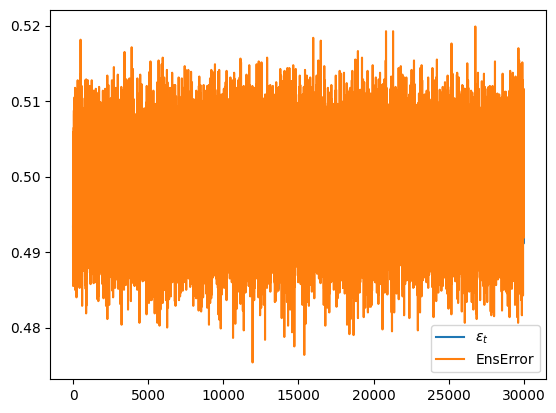

In [42]:
plt.plot(a.wl_errors, label=r"$\epsilon_t$")
plt.plot(a.ens_errors, label="EnsError")
plt.legend()

In [38]:
train_accuracy = sum(y_train_ == y_train) / len(y_train)
train_error = sum(y_train_ != y_train) / len(y_train)

test_accuracy = sum(y_test == y_test_) / len(y_test)
train_error = sum(y_test != y_test_) / len(y_test)

test_accuracy

np.float64(0.498)